In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 
import  pickle


import sys 
sys.path.append('../code_general_Finkelsteinlab/')
import Process_SeqLibrary_Finkelsteinlab as Finkellib
reload(Finkellib);


sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA 

from scipy.optimize import curve_fit

In [2]:
data = pickle.load(open('D-dCas9-sequence-cluster-IntensityAtConcentration.txt'))

In [3]:
datadict = dict(data)

In [4]:
def collect_all_clusters(CHAMP_data, concentrations, target_seq, Cas):
    '''
    returns a dataframe with every row being a single cluster. 
    Hence, every sequence is repeated as there are multiple clusters with the same sequence
    
    
    Can be used later to get the median binding curve
    '''
    Seq = []
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    c5 = []
    c6 = []
    c7 = []
    c8 = []
    c9 = []
    for sequence in datadict.keys():
        for cluster , curve in enumerate(datadict[sequence]):
            Seq.append(sequence)
            c1.append(curve[0]) 
            c2.append(curve[1]) 
            c3.append(curve[2]) 
            c4.append(curve[3]) 
            c5.append(curve[4]) 
            c6.append(curve[5]) 
            c7.append(curve[6]) 
            c8.append(curve[7]) 
            c9.append(curve[8])     
    df = pd.DataFrame()
    df['sequence'] = Seq
    df[str(concentrations[0]) + 'nM'] = c1
    df[str(concentrations[1]) + 'nM'] = c2
    df[str(concentrations[2]) + 'nM'] = c3
    df[str(concentrations[3]) + 'nM'] = c4
    df[str(concentrations[4]) + 'nM'] = c5
    df[str(concentrations[5]) + 'nM'] = c6
    df[str(concentrations[6]) + 'nM'] = c7
    df[str(concentrations[7]) + 'nM'] = c8
    df[str(concentrations[8]) + 'nM'] = c9
    
    
    # find on-target, canonical PAM , etc. 
    df['On Target'] = df['sequence'].apply(lambda S: Finkellib.find_ontarget(S, target_seq, Cas))
    df['PAM'] = df['sequence'].apply(lambda S: Finkellib.separate_PAM(S, Cas)[0])
    df['Canonical'] = df['sequence'].apply(lambda S: Finkellib.separate_PAM(S, Cas)[2])
    return df


def substract_background(df, concentrations):
    background = df['0nM'].copy()
    for c in concentrations:
        df[str(c) + 'nM'] = df[str(c) + 'nM'] - background
    return df


def find_saturation(df, concentrations):
    OnTarget = df[df['On Target'] & df['Canonical'] ].copy()
    saturation_value = OnTarget[str(concentrations[-1])+'nM'].median()
    return saturation_value


def row_to_list(row, concentrations):
    binding_curve = []
    for c in concentrations:
        binding_curve.append( row[str(c)+'nM']  )
    return np.array(binding_curve)
    

def get_binding_curves(df, concentrations):
    '''
    get the equivalent of bound fraction:
        (I(c) - Imin )/(Imax - Imin)
    with 
    * I(c) the fluoresence intensity at concentration c, 
    * Imin the background fluoresence determined seperately for every cluster
    * Imax the value the on-target attains at saturation (determined based on median over clusters) 
    '''
    
    # remove the clusters for which there is not a complete binding curve available:
    df.dropna(axis=0,inplace=True)
    

    no_Imin = substract_background(df, concentrations)
    PreMedian = no_Imin.drop(['On Target','PAM','Canonical'],axis=1).copy()   
    Medians = PreMedian.groupby('sequence').median(skipna=True) 
    Imax = find_saturation(df,concentrations)
    
    binding_curves = []
    for i in range(len(Medians)):
        binding_curves.append( row_to_list(Medians.iloc[i], concentrations)/Imax )
    Medians['binding_curves'] = binding_curves
    return Medians 


def Hill_eq(C, Kd):
    return (1.0+Kd/C)**(-1)

def get_ABA(df, concentrations):
    df['ABA'] = df['binding_curves'].apply(lambda x: np.log(curve_fit(Hill_eq, concentrations,x)[0][0]) )
    return df 


def bootstrap_ABA(grouped,  nmbr_runs,Imax, concentrations):
    bstrp_ABA = []
    for run in range(nmbr_runs):
        # --- bootstrap sample cluster (per given sequence) ----- 
        bstrp_sample = grouped.sample(n=len(grouped),replace=True)
        
        # --- get our new 'median' binding curve ----
        bstrp_med = bstrp_sample.median()
        bstrp_binding_curve = row_to_list(bstrp_med, concentrations)/Imax
    
        # --- calculate ABA --- 
        bstrp_ABA.append( np.log(curve_fit(Hill_eq, concentrations[1:], bstrp_binding_curve[1:])[0][0] ) )
        
    bstrp_ABA = np.array(bstrp_ABA)
    return np.mean(bstrp_ABA), np.std(bstrp_ABA)




def build_dataframe_for_fitting( full_data,  nmbr_boot, concentrations ):
    # remove the clusters for which there is not a complete binding curve available:
    full_data.dropna(axis=0,inplace=True)
    
    # --- substract background ---- 
    minus_Imin = substract_background(full_data, concentrations)
    
    # --- saturation level (to convert into bound fraction) ----
    Imax = find_saturation(full_data,concentrations)
    
    # --- for every sequence: use bootstrapping to find avg. ABA and errorbar ABA ---- 
    sequences = []
    ABA = []
    error = []
    
    
    all_seqs = minus_Imin.drop(['On Target','PAM','Canonical'],axis=1).copy() 

    for name,group in all_seqs.groupby('sequence'):
        # --- perform bootstrapping on ABA values for this sequence  ----
        avg, std = bootstrap_ABA(group,nmbr_boot, Imax ,concentrations  )
        
        # --- store results into processed dataframe ---- 
        sequences.append(name)
        ABA.append(avg)
        error.append(std)
        
    # --- stroe results into processed dataframe ---- 
    processed_data = pd.DataFrame()
    processed_data['sequence'] = sequences
    processed_data['ABA'] = ABA
    processed_data['error'] = error
    
    return processed_data


In [5]:
concentrations = [0, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
target_D = 'TTTAGTGATAAGTGGAATGCCATGTGG'
Cas = 'Cas9'

df = collect_all_clusters(CHAMP_data=datadict,
                          concentrations=concentrations, 
                          target_seq=target_D, 
                          Cas=Cas)

In [6]:
processed_data = build_dataframe_for_fitting(df, nmbr_boot=100,concentrations=concentrations)

In [8]:
processed_data.to_csv('./TargetD-dCas9_AbsoluteABA_raw.csv', index=False)

In [72]:
2500/3600. * 60 

41.666666666666664

In [9]:
%%timeit
Medians = get_binding_curves(df,concentrations)


dfABA = Medians.copy()
dfABA = get_ABA(dfABA,concentrations)
dfABA.reset_index(inplace=True)

1 loop, best of 3: 9.46 s per loop


In [10]:
df

,sequence,0nM,0.1nM,0.3nM,1nM,3nM,10nM,30nM,100nM,300nM,On Target,PAM,Canonical
0,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,1746.781981,-4596.178288,-7132.316567,-3312.054811,801.283653,14408.251817,23616.255059,41555.362106,False,AGG,True
1,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,1429.945854,-3935.644108,-5271.131604,-2207.523804,2544.767345,15501.718137,25832.458112,39837.156175,False,AGG,True
3,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,-1122.285616,-7596.968108,-12147.880743,-6428.930892,-4310.519875,3063.070406,14369.327237,29483.631544,False,AGG,True
4,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,-1157.097168,-7968.655452,-16062.621957,-12468.683817,-8830.177885,641.116486,4973.865310,21067.059126,False,AGG,True
5,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,1889.548953,-4618.290109,-6265.008407,-2702.939611,530.017651,15085.323630,20945.182629,37972.064297,False,AGG,True
6,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,1377.326620,-5101.740307,-6941.747125,-3723.634450,-537.823329,6997.129548,14119.250896,27560.901973,False,AGG,True
7,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,686.739972,-7953.859932,-11684.496290,-8052.575708,-5184.452085,6666.506498,12431.482636,27461.227331,False,AGG,True
8,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,-1407.434868,-12614.638995,-16645.967038,-16151.727283,-14080.778985,-4538.958815,7686.489328,13651.734298,False,AGG,True
9,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,944.073145,-3961.977022,-7147.679399,-2906.091548,1892.050311,14300.918781,24807.378786,42908.214946,False,AGG,True
10,TGTTAGTGATAAGTGGAATGCCATGTAGG,0.0,-609.096022,-11149.910268,-14876.160904,-11259.777475,-7207.607242,1090.116546,10752.684063,24142.210258,False,AGG,True


In [75]:
# find on-target, canonical PAM , etc. 
dfABA['On Target'] = dfABA['sequence'].apply(lambda S: Finkellib.find_ontarget(S, target_D, Cas))
dfABA['PAM'] = dfABA['sequence'].apply(lambda S: Finkellib.separate_PAM(S, Cas)[0])
dfABA['Canonical'] = dfABA['sequence'].apply(lambda S: Finkellib.separate_PAM(S, Cas)[2])

canonical_ABA = dfABA[dfABA['On Target'] & dfABA['Canonical']].copy()
reference_ABA = canonical_ABA.ABA.median()
dfABA['DeltaABA'] = dfABA['ABA'] - reference_ABA

In [95]:
dfABA.ABA.min(), dfABA.ABA.max()

(3.5962803331134472, 8.0267283709919859)

In [80]:
previous_ABA_data = pd.read_table('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-d-replicate-1-delta-abas.txt',
                                 skiprows=3)

array([[ 1.        ,  0.98837358],
       [ 0.98837358,  1.        ]])

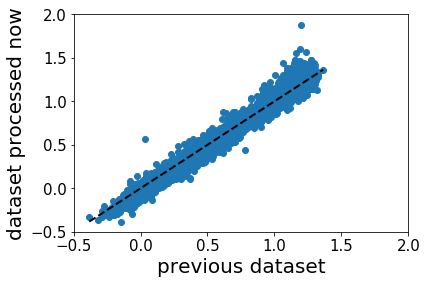

In [94]:
merged = pd.merge(previous_ABA_data, dfABA, how='inner',left_on='# Sequence', right_on='sequence')

plt.scatter(merged['Delta ABA (kBT)'], merged['DeltaABA'])
plt.xlabel('previous dataset',fontsize=20)
plt.ylabel('dataset processed now',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

x = np.linspace(np.min(merged['Delta ABA (kBT)']),np.max(merged['Delta ABA (kBT)']), 1000)
plt.plot(x,x, linestyle='dashed',linewidth=2, color='black');
plt.ylim(-0.5,2)
plt.xlim(-0.5,2);



In [97]:
len(merged), len(previous_ABA_data), len(dfABA), len(dfABA)-len(previous_ABA_data)

(7509, 7509, 7534, 25)

In [99]:
df_dABA= Finkellib.process_Finkelstein_Library(data=merged, 
                                      on_target=target_D, 
                                      seq_colname='sequence', 
                                      output_colnames=['DeltaABA'],
                                      nofilter=True,
                                      out_file_name='CHAMP_dCas9_targetD_preprocessed.csv', out_path='./',
                                      save_data=False
                                      )




In [101]:
df_dABA.rename(columns={'DeltaABA':'Delta ABA (kBT)'},inplace=True)

In [103]:
df_dABA['Uncertainty'] = 0.0

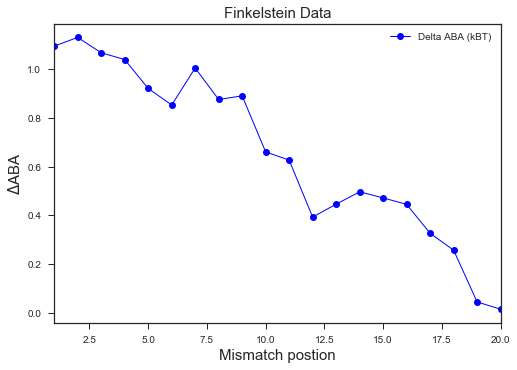

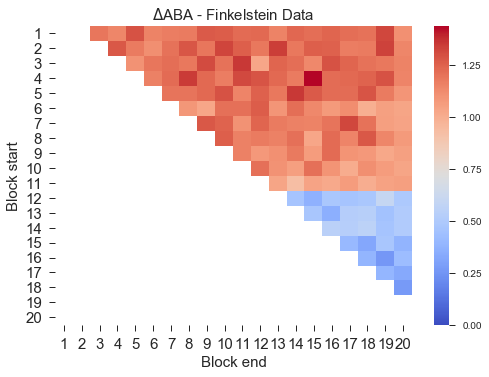

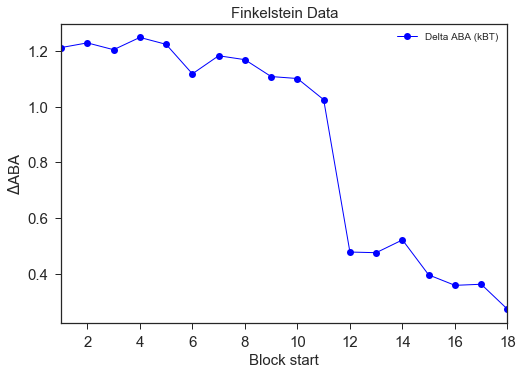

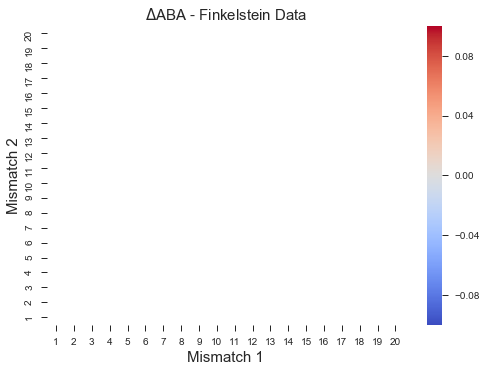

In [110]:
pltABA.plot_single_mut_ABA(data=df_dABA, Mut_type='r');
pltABA.plot_block_mm_ABA(df_dABA);
pltABA.plot_double_mut_ABA(df_dABA,Mut_type='r');